# Заняття 15

## Суть роботи:
Оцінити продуктивність генеративної моделі GenAI за допомогою відповідних метрик та методів, а також запропонувати покращення, що допоможуть підвищити її ефективність або якість результатів.


## Кроки для виконання завдання:

### 1. Визначення мети оцінки:
- Чітко сформулюйте, що саме ви хочете оцінити в моделі GenAI (наприклад, якість згенерованих текстів, візуальну якість зображень, точність аудіо).
- Визначте, чи потрібно оцінювати модель за точністю, креативністю або іншими специфічними характеристиками, які важливі для даного проєкту.


### 2. Вибір метрик для оцінки:
#### Для текстових моделей:
- Метрики якості тексту: **BLEU**, **ROUGE**, **METEOR** для порівняння з еталонними текстами.
- Оцінка довготривалих залежностей: **Perplexity**, якщо текст повинен мати логічну структуру.
- Людська оцінка (**Human Evaluation**) для суб’єктивного аналізу якості та доречності.

#### Для зображень:
- **Structural Similarity Index (SSIM)** для порівняння з еталонними зображеннями.
- **Frechet Inception Distance (FID)** та **Inception Score** для оцінки якості зображень та схожості на навчальні дані.
- Візуальна перевірка для оцінки якості генерації очима.

#### Для аудіо або музичних моделей:
- **Mean Opinion Score (MOS)** для суб’єктивної оцінки якості аудіо.
- **Spectral Analysis** для порівняння аудіоспектрів із реальними прикладами.


### 3. Збір даних для оцінки:
- Визначте набір тестових даних, який дозволить об’єктивно оцінити продуктивність моделі. Тестові дані мають бути незалежними від навчального набору.
- Якщо можливо, зберіть еталонні зразки або скористайтеся даними з реального середовища для порівняння.


### 4. Проведення оцінки:
- Виконайте оцінку моделі за допомогою обраних метрик, зібравши показники продуктивності (наприклад, середнє значення BLEU або FID).
- Якщо є суб’єктивні аспекти оцінки (наприклад, природність мови), залучіть групу рецензентів для збору людських оцінок.


### 5. Аналіз результатів:
- Проаналізуйте отримані результати за кожною з метрик. Визначте, де модель працює добре, а де показує слабкі результати.
- Порівняйте продуктивність із початковими очікуваннями або базовими моделями, якщо це можливо.


## Мінімальні вимоги:
- Провести оцінку моделі GenAI за допомогою відповідних метрик.
- Проаналізувати результати та запропонувати покращення для підвищення якості.


## Формат виконання:
- Текстова доповідь або презентація зі зразками коду обчислення метрик.


## Реалізація

### Підготовка

In [60]:
%pip install torch torchvision
%pip install transformers
%pip install lpips

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [61]:
# Standard library imports
import os
from typing import Tuple

# Third-party imports
import cv2
from IPython.display import HTML
import lpips
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from skimage.metrics import structural_similarity as ssim
import torch
import torchvision.transforms as T
from transformers import CLIPModel, CLIPProcessor

In [62]:

original_dir = "data/original"
generated_dir = "data/generated"
description_dir = "data/description"

IMAGES = [
    "001.png",
    "002.png",
    "003.png",
    "004.png",
    "005.png",
    "006.png",
    "007.png",
    "008.png",
    "009.png",
]

METRICS = {"IMAGES": IMAGES, "SSIM": [], "LPIPS": [], "CLIP": []}

In [63]:

def print_images(file_name):

    sketch_path = os.path.join(original_dir, file_name)
    gen_path = os.path.join(generated_dir, file_name)

    # Display the images side by side
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.imread(sketch_path)[..., ::-1])
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.imread(gen_path)[..., ::-1])
    plt.title('Generated')
    plt.axis('off')
    plt.show()

### 1. Визначення мети оцінки

Перш ніж розпочинати обчислення метрик і порівнянь, важливо **чітко визначити**, що саме ми хочемо перевірити або вдосконалити в нашій моделі **GenAI**, яка генерує зображення на основі скетчів і текстових описів. У цьому контексті можна виділити такі ключові цілі:

1. **Візуальна якість та реалістичність**  
   - Оцінити, наскільки згенеровані зображення відповідають реалістичним стандартам (кольори, текстури, пропорції).  
   - Перевірити, чи немає в результатах значних артефактів або спотворень.

2. **Збереження структури та форми об’єктів**  
   - Переконатися, що модель коректно інтерпретує контури та пропорції скетчу й переносить їх у згенероване зображення.  
   - Виявити, наскільки модель «відходить» від початкової ідеї або композиції.

3. **Семантична відповідність**  
   - Перевірити, чи зображення візуалізує ті самі об’єкти, сюжет або сцену, які були передбачені в ескізі та/або текстовому описі.  
   - Оцінити, наскільки гармонійно модель поєднує елементи скетчу з текстовим описом (за наявності) та зберігає логіку сцени.

4. **Суб’єктивні та креативні аспекти**  
   - Якщо завдання передбачає креативність (наприклад, стилізацію, художнє бачення), варто враховувати ступінь «оригінальності» чи «естетичності».  
   - Залучити людську оцінку (Human Evaluation), щоб визначити, чи відповідає результат дизайнерському баченню чи контексту проєкту.

5. **Можливі обмеження та сфера застосування**  
   - Врахувати, чи результати підходять для реальних умов використання (наприклад, ілюстрації, маркетингові матеріали, дизайн прототипів тощо).  
   - Заздалегідь визначити, які недоліки можна пробачити моделі, а які є критичними для проєкту.

Таким чином, **головна мета** оцінки полягає в тому, щоб виміряти, наскільки модель GenAI **зберігає структуру** скетчу, **генерує якісне зображення** та **відповідає очікуваній семантиці**. Це дає змогу визначити, де модель працює добре, а де їй потрібне доопрацювання чи додаткові дані для тренування.

### 2. Вибір метрик для оцінки

Оскільки наш проєкт зосереджений на **зображеннях**, ми не розглядаємо текстові чи аудіо-метрики. Замість цього обираємо ті метрики, які найкраще показують **перцептивну, структурну та семантичну** відповідність згенерованого зображення до вихідного скетчу (або референсних даних). У результаті ми застосовуємо:

#### **Structural Similarity Index (SSIM)**  
   - Вимірює структурну подібність двох зображень, беручи до уваги локальні зміни яскравості, контрасту та текстур.  
   - Використовуємо, щоб оцінити, наскільки зберігаються форми та контури об’єктів із вихідного ескізу.



In [64]:
"""Module for computing Structural Similarity Index (SSIM) between images."""


class SSIMMetric:
    """
    **SSIM (Structural Similarity Index)**
    - **Опис**: Вимірює структурну схожість між двома зображеннями, враховуючи яскравість, контрастність і структуру.
    - **Діапазон значень**: Від 0 до 1.
      - **1**: Ідеальна структурна схожість (зображення ідентичні).
      - **0**: Відсутність структурної схожості.
    - **Трактування**:
      - **0.8–1.0**: Висока схожість між зображеннями.
      - **0.5–0.8**: Помітні структурні відмінності, але частково схожі.
      - **< 0.5**: Значна різниця в структурі зображень.
    """

    def __init__(self):
        """
        Initialize SSIMMetric with paths to two images.
        """

    @staticmethod
    def load_and_preprocess_image(image_path: str) -> np.ndarray:
        """
        Load and preprocess an image from the given path.

        Args:
            image_path (str): Path to the image file.

        Returns:
            np.ndarray: Grayscale image as a numpy array.
        """
        return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    @staticmethod
    def ensure_same_dimensions(
        image1: np.ndarray, image2: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Ensure that both images have the same dimensions.

        Args:
            image1 (np.ndarray): First image.
            image2 (np.ndarray): Second image.

        Returns:
            Tuple[np.ndarray, np.ndarray]: Tuple of images with the same dimensions.
        """
        if image1.shape != image2.shape:
            image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))
        return image1, image2

    def compute_ssim(self, image1_path: str, image2_path: str) -> float:
        """
        Compute the Structural Similarity Index (SSIM) between two images.

        Returns:
            float: SSIM score between the two images.
        """
        image1 = self.load_and_preprocess_image(image1_path)
        image2 = self.load_and_preprocess_image(image2_path)

        image1, image2 = self.ensure_same_dimensions(image1, image2)

        score, _ = ssim(image1, image2, full=True)
        return float(score)



#### **Learned Perceptual Image Patch Similarity (LPIPS)**  
   - Оцінює «перцептивну» схожість на рівні глибинних ознак нейронної мережі.  
   - Дає змогу зрозуміти, наскільки візуальний вигляд і деталі згенерованого зображення відповідають «початковій ідеї» (скетчу).


In [65]:

# 1. Створюємо модель LPIPS
# net='alex' або 'vgg' чи 'squeeze' - це варіанти бектендів
lpips_model = lpips.LPIPS(net="alex")

# 2. Трансформація для узгодженого розміру та перетворення в Tensor
transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.ToTensor(),
    ]
)


def compute_lpips_distance(img_path1, img_path2):
    # Завантажуємо зображення
    img1 = Image.open(img_path1).convert("RGB")
    img2 = Image.open(img_path2).convert("RGB")

    # Застосовуємо трансформацію (Resize, ToTensor)
    img1 = transform(img1)
    img2 = transform(img2)

    # Додаємо batch dimension (N=1)
    img1 = img1.unsqueeze(0)
    img2 = img2.unsqueeze(0)

    # Рахуємо LPIPS
    with torch.no_grad():
        dist = lpips_model(img1, img2)  # dist - тензор розміром [1, 1, 1, 1]
    return dist.item()  # Перетворюємо в скаляр

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/Users/yuri/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yuri/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/yuri/.pyenv/versions/3.10.13/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


/Users/yuri/.pyenv/versions/3.10.13/lib/python3.10/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path


#### **CLIP-based Similarity**  
   - Семантична міра схожості між двома зображеннями (згідно з CLIP), яка покаже, чи зображені однакові об’єкти / сцени / концепти.  
   - Ідеальна для завдань, де важливо зберегти «сенс» або сюжет з ескізу.


In [66]:

# 1. Ініціалізуємо модель та процесор CLIP
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Device: {device}")

model_id = "openai/clip-vit-base-patch32"

model = CLIPModel.from_pretrained(model_id).to(device)
processor = CLIPProcessor.from_pretrained(model_id)


# 2. Функція для витягування CLIP-ембедингів зображення
def get_clip_image_embedding(image_path: str) -> np.ndarray:
    """
    Повертає вектор ембедингу (1, d) для зображення, обчислений CLIP.
    """
    image = Image.open(image_path).convert("RGB")

    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        image_features = model.get_image_features(**inputs)

    image_features = image_features.cpu().numpy()
    image_features = image_features / np.linalg.norm(
        image_features, axis=1, keepdims=True
    )

    return image_features


# 3. Функція для обчислення косинусної подібності між двома векторами
def cosine_similarity(vec1: np.ndarray, vec2: np.ndarray) -> float:
    """
    Приймає два вектори (1,d) та повертає скаляр (cosine similarity).
    """
    return float(np.sum(vec1 * vec2, axis=1))  # для (1,d) це просто скаляр

Device: mps


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



#### **Візуальна перевірка (Manual Check)**  
   - Додаткова суб’єктивна оцінка, аби побачити, чи немає артефактів, чи справді зображення виглядає привабливо й реалістично.  
   - Надійна особливо в тих аспектах, які не завжди коректно відображаються в автоматичних метриках (креативність, художній стиль тощо).

> **Примітка**:  
> - **Frechet Inception Distance (FID)** та **Inception Score** зазвичай використовують для порівняння *двох подібних розподілів зображень* (наприклад, «реальні» vs. «згенеровані»). Наші референсні зображення та згенеровані картинки належать до дуже різних доменів (скетч vs. фотореалізм), FID може бути менш інформативним. 

### 3. Збір даних для оцінки

1. **Формування тестового набору**  
   


Name,001.png,002.png,003.png,004.png,005.png,006.png,007.png,008.png,009.png
Original,,,,,,,,,
Generated,,,,,,,,,
Description,"A realistic digital painting of a young woman with curly, voluminous dark hair, her face is slightly angled to her right with a neutral expression, her posture is relaxed with arms crossed at her waist, she's wearing a short dress that crosses at the bodice with a triangular pattern, her legs are long and her feet appear in rounded shoes with large soles, the lighting is a soft, diffused light casting subtle shadows, the style should be reminiscent of a modern fashion illustration with detailed rendering of fabric, hair, and skin, the overall tone is warm and inviting, the background is plain and light to ensure the focus remains entirely on the subject.","A realistic image of a modern laptop, angled straight-on in a well-lit environment. The laptop is open, with the screen displaying a video play icon in a dark background. The keyboard below is clearly defined with individual, slightly raised keys and a flat trackpad in the center. The laptop's material has a smooth texture with a matte finish, and the background is plain and minimalist. The lighting should be subtle and soft, suggesting a well-lit room, with light casting gentle shadows from the keys and edges of the laptop.","A realistic image of a fish, viewed from its side. The fish has a rounded body with a pointed head, a distinct dorsal fin on its back, a pectoral fin near its gill, and a tail fin. Its body has a wavy pattern with the light brown color. The fish appears to be swimming in clear water, with natural lighting creating subtle shadows. The image should aim for a photo-realistic style, focusing on accurately depicting the fish's texture, scales, and coloration, with a glossy, smooth finish.","A realistically rendered, slightly angled view of a square gift box with a tied bow on top. The box is wrapped in paper with a vertical ribbon, creating sections on the front. The box sits flat on a surface. The ribbon and bow should be realistically detailed with folds, the paper has a matte finish and is smooth. The lighting is soft and diffused, creating subtle shadows, giving the scene a calm and celebratory feel. The scene is a close-up, focusing on the details of the gift box. The colors of the bow and wrapping paper are vibrant and rich, creating a nice contrast.","A realistic image of train traveling on a railroad track with an airplane flying above, set against a flat landscape under clear daylight. Key elements include a metallic train with red accents, a glossy airplane, and a simple ground, all aiming for photographic realism with natural lighting and soft shadows.","The scene centers on a cheerful snowman made of three large snowballs, adorned with a bucket hat, button eyes, and a carrot nose, set against a serene winter landscape. Soft, diffused daylight enhances the photo-realistic textures of the snow and vibrant colors of the accessories, creating a joyful atmosphere.","A highly realistic, close-up shot of a single daisy flower with smooth white petals and a textured yellow center. The petals should have subtle variations in their curvature and slight shadows to give them depth. The flower is placed on a thin green stem with a single, elongated, slightly curved green leaf extending from the base of the stem. The lighting is soft, natural daylight coming from above, casting gentle shadows that give a three-dimensional feel. The background is plain and softly blurred to keep the focus on the flower, giving a photographic style. The flower should be in focus and sharp, with the leaf also being well-defined, with a hint of gloss on its surface. The stem should be a deep, matte green. The whole composition should feel organic and vibrant, capturing the beauty of a simple flower.","A realistic image of a cute teddy bear with round ears, circular eyes wearing glasses, a smiling face, a round body, and circular hands and legs. The bear i
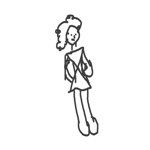
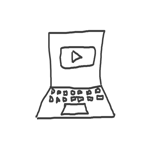
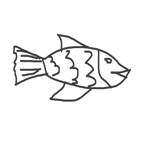
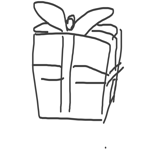
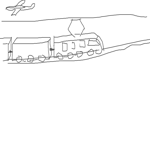
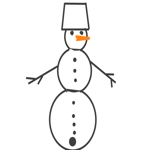
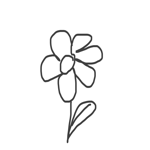
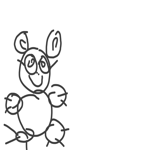
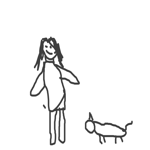
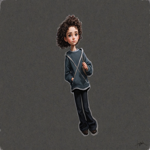
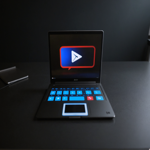
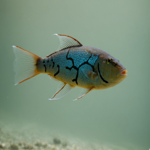
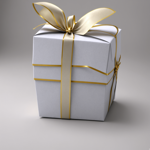
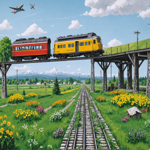
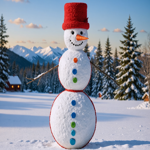
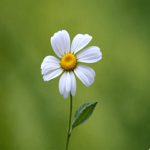
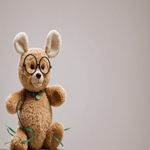
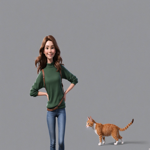

In [82]:
import base64
from io import BytesIO

# Read descriptions for each image
data = {"Name": ["Original", "Generated", "Description"]}


def img_to_base64(img_path):
    with open(img_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode("utf-8")

def img_template(img_file, dir):
    img_path = os.path.join(dir, img_file)
    img = Image.open(img_path)
    img = img.resize((150, 150))
    # Convert PIL Image to bytes
    buffer = BytesIO()
    img.save(buffer, format="PNG")
    img_data = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return f'<img src="data:image/png;base64,{img_data}" width="150" height="150">'


for img_file in IMAGES:
    desc_file = os.path.join(description_dir, img_file.replace(".png", ".txt"))
    row = []

    row.append(img_template(img_file, original_dir))
    row.append(img_template(img_file, generated_dir))

    # Add description
    if os.path.exists(desc_file):
        with open(desc_file, "r", encoding="utf-8") as f:
            row.append(f.read().strip())
    else:
        row.append("")

    data[img_file] = row

df = pd.DataFrame(data)
HTML(df.to_html(escape=False, index=False))


2. **Збір відповідних згенерованих результатів**  
   - Для кожного скетча є *відповідні* згенеровані зображення, які модель створювала за однаковим сценарієм: заданий скетч + текстовий опис. 

Таким чином, **заздалегідь** зібрані *скетчі, відповідні текстові описи та згенеровані зображення* (не з навчальної вибірки) дозволять повною мірою протестувати модель GenAI за допомогою обраних метрик (SSIM, LPIPS, CLIP similarity) і зробити виважені висновки про її продуктивність.

### 4. Проведення оцінки

#### **Автоматична оцінка за обраними метриками**  
##### **SSIM (Structural Similarity)**:  
     - Для кожної пари «скетч &rarr; згенероване зображення» ми обчислювали показник, що характеризує збереження локальних структур і контрасту.  
     - Отримані значення SSIM дали змогу визначити, наскільки сильно модель змінює або спотворює початковий задум.


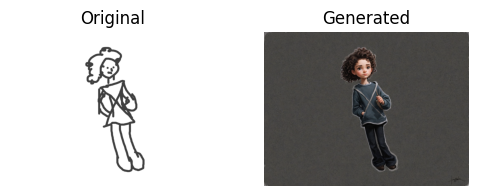

SSIM for 001.png: 0.4256
------------------------------------------------------------


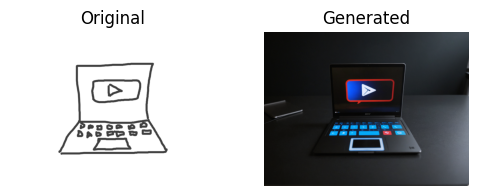

SSIM for 002.png: 0.2479
------------------------------------------------------------


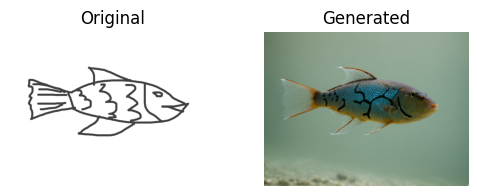

SSIM for 003.png: 0.7263
------------------------------------------------------------


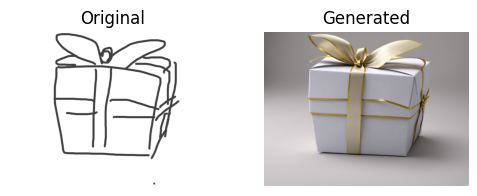

SSIM for 004.png: 0.7795
------------------------------------------------------------


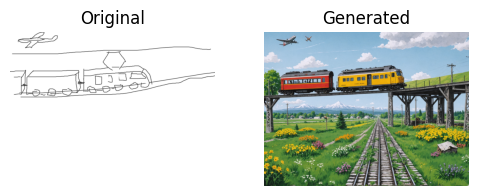

SSIM for 005.png: 0.4332
------------------------------------------------------------


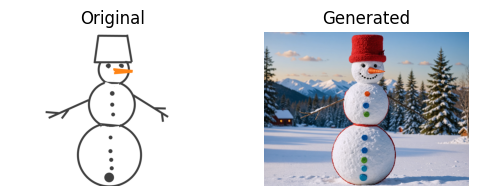

SSIM for 006.png: 0.5765
------------------------------------------------------------


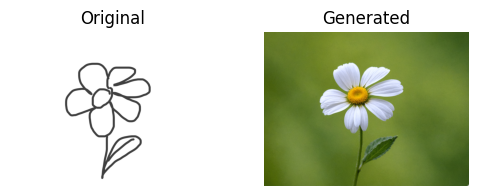

SSIM for 007.png: 0.6508
------------------------------------------------------------


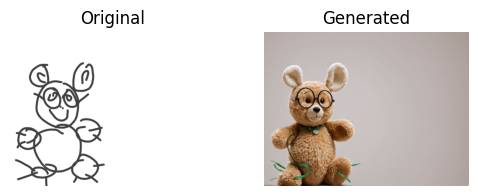

SSIM for 008.png: 0.7866
------------------------------------------------------------


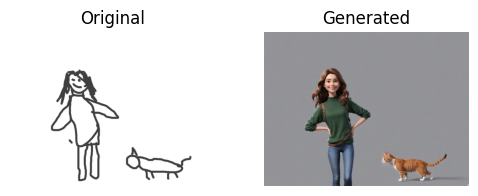

SSIM for 009.png: 0.7464
------------------------------------------------------------


In [68]:

ssim_metric = SSIMMetric()

for img_file in IMAGES:
    orig_image = os.path.join(original_dir, img_file)
    gen_image = os.path.join(generated_dir, img_file)

    print_images(img_file)

    ssim_score = ssim_metric.compute_ssim(orig_image, gen_image)
    METRICS["SSIM"].append(ssim_score)
    print(f"SSIM for {img_file}: {ssim_score:.4f}")
    print("-" * 60)

Наведені значення **SSIM** (Structural Similarity Index) відображають, наскільки *структурно* подібні пари зображень (скетч vs. згенероване). **SSIM** змінюється в діапазоні \([0,1]\), де:
- **1.0** означає ідентичні зображення (у сенсі локальної яскравості, контрасту та структури),
- **0.0** свідчить про кардинальну відмінність.

**Підсумок**
- **Високі** значення (0.65–0.78) (наприклад, 004.png, 008.png, 009.png) вказують, що модель у цих випадках *зберегла* ключові риси оригіналу.  
- **Низькі** значення (0.24–0.43) (наприклад, 002.png, 001.png, 005.png) свідчать про значні зміни в структурі порівняно зі скетчем.  



##### **LPIPS (Learned Perceptual Image Patch Similarity)**:  
     - Дає уявлення про «перцептивну» схожість із точки зору глибинних ознак.  
     - Чим **менше** LPIPS, тим ближчими виявляються результати до ескізів на рівні високорівневих характеристик.


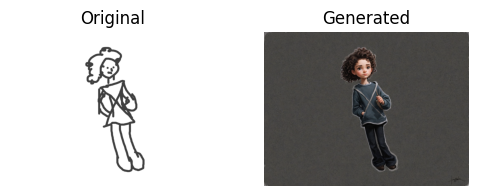

001.png LPIPS distance = 0.3872
------------------------------------------------------------


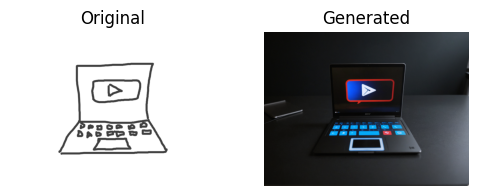

002.png LPIPS distance = 0.5153
------------------------------------------------------------


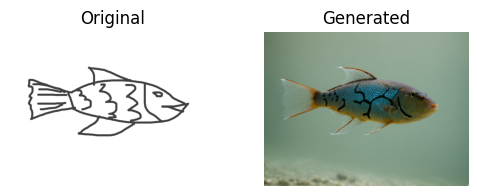

003.png LPIPS distance = 0.3862
------------------------------------------------------------


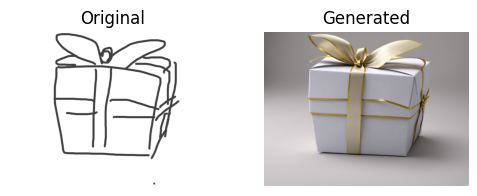

004.png LPIPS distance = 0.3284
------------------------------------------------------------


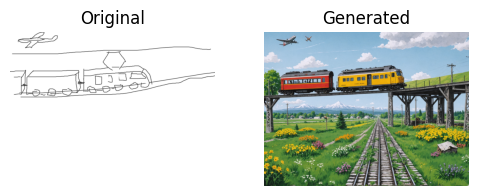

005.png LPIPS distance = 0.6993
------------------------------------------------------------


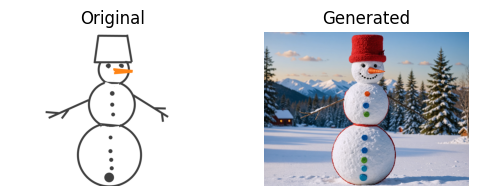

006.png LPIPS distance = 0.5225
------------------------------------------------------------


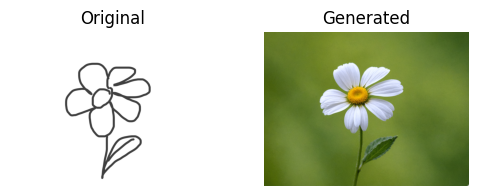

007.png LPIPS distance = 0.4876
------------------------------------------------------------


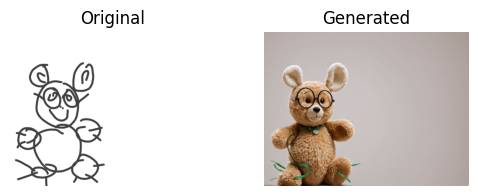

008.png LPIPS distance = 0.2767
------------------------------------------------------------


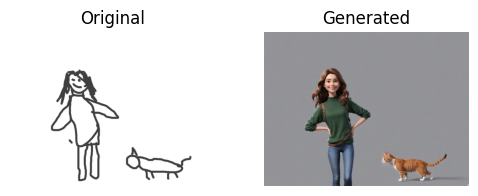

009.png LPIPS distance = 0.2557
------------------------------------------------------------


In [69]:
for file_name in IMAGES:

    sketch_path = os.path.join(original_dir, file_name)
    gen_path    = os.path.join(generated_dir, file_name)

    if os.path.isfile(sketch_path) and os.path.isfile(gen_path):
        distance = compute_lpips_distance(sketch_path, gen_path)
        METRICS["LPIPS"].append(distance)
        print_images(file_name)

        print(f"{file_name} LPIPS distance = {distance:.4f}")
        print("-" * 60)

    else:
        print(f"Пропускаємо {file_name} - файл не знайдено!")

**Висновок**

- **Низькі** значення LPIPS (0.25–0.35) свідчать, що згенероване зображення *ближче за структурою та текстурою* до скетча.  
- **Вищі** (0.50–0.70) -- вказують на суттєві зміни/відмінності.  
- З погляду «перцептивної» схожості, 009.png та 008.png, схоже, *найбільш подібні* до оригінальних скетчів, тоді як 005.png -- *найменш*.  

Загалом, ці числа можуть бути добрим **відносним показником** для порівняння пар «скетч -> згенероване», але самі по собі не є абсолютним критерієм якості.


##### **CLIP-based Similarity**:  
     - Вимірює *семантичну* близькість між вихідним скетчем і згенерованим зображенням.  
     - Чим **вище** косинусна подібність, тим краще модель зберігає основну ідею та предметну складову.


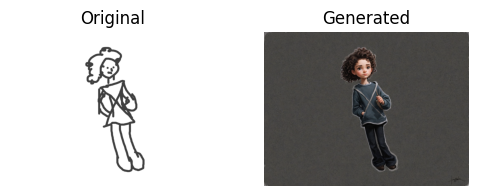

/var/folders/r0/g6z_mwgj0p36313ykwd6xyf80000gn/T/ipykernel_92113/933152991.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(np.sum(vec1 * vec2, axis=1))  # для (1,d) це просто скаляр


001.png | CLIP Cosine Similarity = 0.7167


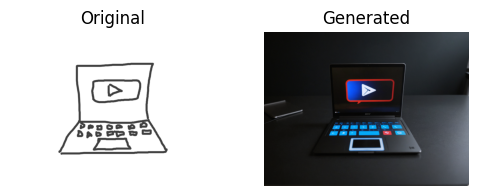

002.png | CLIP Cosine Similarity = 0.7903


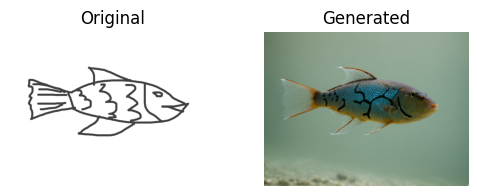

003.png | CLIP Cosine Similarity = 0.7406


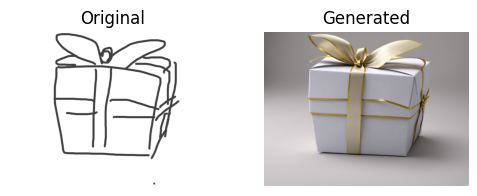

004.png | CLIP Cosine Similarity = 0.8135


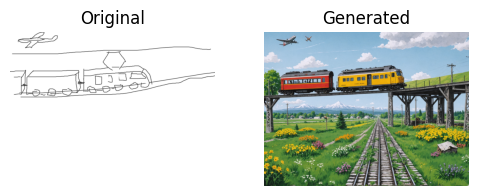

005.png | CLIP Cosine Similarity = 0.6281


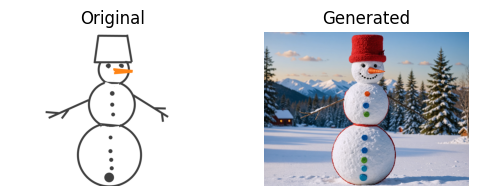

006.png | CLIP Cosine Similarity = 0.8884


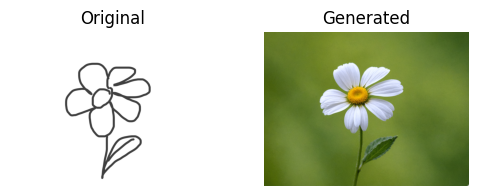

007.png | CLIP Cosine Similarity = 0.7809


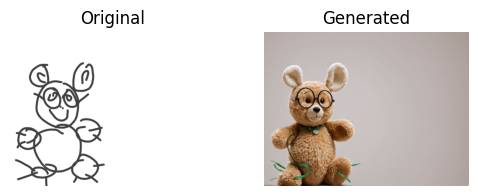

008.png | CLIP Cosine Similarity = 0.7694


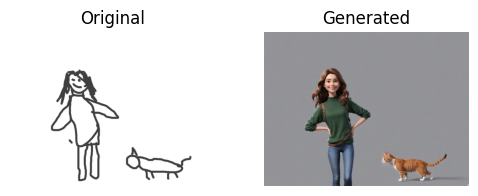

009.png | CLIP Cosine Similarity = 0.6911


In [70]:
for file_name in IMAGES:
    sketch_path = os.path.join(original_dir, file_name)
    gen_path = os.path.join(generated_dir, file_name)

    if os.path.isfile(sketch_path) and os.path.isfile(gen_path):
        # Витягуємо вектори CLIP
        sketch_emb = get_clip_image_embedding(sketch_path)  # shape (1, d)
        gen_emb = get_clip_image_embedding(gen_path)  # shape (1, d)

        print_images(file_name)
        # Косинусна подібність
        sim_score = cosine_similarity(sketch_emb, gen_emb)

        METRICS["CLIP"].append(sim_score)

        print(f"{file_name} | CLIP Cosine Similarity = {sim_score:.4f}")
    else:
        print(f"Пропускаємо {file_name} - файл не знайдено!")

Результати **CLIP Cosine Similarity** демонструють, наскільки, на думку моделі CLIP, *семантично* близькі ескізи (скетчі) та згенеровані зображення. Косинусна подібність змінюється від \(-1\) до \(+1\), де:

- **+1** означає майже ідентичні вектори в семантичному просторі CLIP (тобто *дуже схожий зміст*),  
- **0** -- відсутність будь-якої семантичної кореляції,  
- **-1** -- протилежний вектор (фактично ніколи не трапляється в реальних зображеннях).

Ось кілька ключових спостережень:

1. **Усі значення позитивні і досить високі (0.6281 до 0.8884)**  
   Це означає, що CLIP бачить *спільні об’єкти/семантичні ознаки* між скетчами та згенерованими зображеннями. Хоча вони й різного стилю (контурний малюнок vs. більш реалістичний), мережа вважає, що в них зображено схожі сцени/об’єкти.

2. **Найвища подібність** – `0.8884` (для 006.png)  
   - Це може свідчити, що скетч 006 і його згенерований варіант *найбільш відповідні* одне одному з точки зору об’єкта/сцени, розташування елементів, характерних ознак тощо.  
   - Тобто CLIP вирішує: «Ці дві картинки описують приблизно ту саму концепцію».

3. **Найнижча подібність** – `0.6281` (для 005.png)  
   - Це не означає, що зображення погане, але, на думку CLIP, згенерований варіант 005 *менш семантично узгоджений* зі своїм скетчем, ніж інші пари.  
   - Можливо, модель «побачила» в згенерованому результаті якісь нові деталі або зовсім іншу композицію.

4. **Зв’язок із іншими метриками (LPIPS, SSIM)**  
   - **CLIP**-подібність вимірює *семантичну* (і трохи «стильову») близькість. Якщо ви хочете, щоб згенероване зображення залишалося *описом* тієї ж сцени / тих самих об’єктів, вищий показник CLIP може свідчити про кращу «відповідність сюжету».  
   - **SSIM** дивиться на схожість «піксельної структури» і локального контрасту.  
   - **LPIPS** оцінює «перцептивну» схожість на рівні глибинних ознак, але більше з фокусом на текстурі / локальних патернах.  

   Тому картинки з високим SSIM не завжди матимуть найвищу CLIP Cosine Similarity -- вони вимірюють *трохи різні аспекти* схожості.

**Висновок**
У цьому прикладі **CLIP Cosine Similarity** коливається від ~0.63 до ~0.89. Вищі значення (0.80+) вказують на дуже добру семантичну відповідність між скетчем і згенерованим зображенням у поняттях CLIP. Натомість нижчі значення (0.60–0.70) можуть свідчити про те, що згенероване зображення відрізняється в деталях або загальному відчутті сюжету порівняно з оригінальним скетчем.


##### **Агрегований «Final Score»**:  
     - Об’єднаємо ці метрики в єдиний інтегральний показник (наприклад, усереднення нормалізованих SSIM, (1-LPIPS) та CLIP Similarity).  
     - Це спрощує порівняння різних варіантів і дозволяє швидко виявити найкращі/найгірші результати.


**1. Пояснення ідеї «єдиного показника»**

1. **SSIM** і **CLIP**: більші значення &mdash; **краще**.  
2. **LPIPS**: менше значення &mdash; **краще**.  

Щоб об’єднати ці три метрики в один узагальнений «score», можна:
- Виконати **мін-макс нормалізацію** (0..1) для кожної метрики
- Для метрики, де “менше краще” (LPIPS), можна **інвертувати** значення

2. **Сукупний «score»** (наприклад, середнє трьох нормалізованих значень) або з різними ваговими коефіцієнтами, якщо якась метрика важливіша. Для простоти візьмемо *усі рівноважливі*
- У результаті **чим вищий** `final_score`, тим краще (за сукупними критеріями).

**2. Нормалізація та сукупний «score»**

1. Мін-макс нормалізація (0..1)


In [71]:
def min_max_normalize(values):
    vmin = np.min(values)
    vmax = np.max(values)
    return (values - vmin) / (
        vmax - vmin + 1e-9
    )  # додаємо epsilon для уникнення ділення на 0

- Для **SSIM** і **CLIP**: беремо цю нормалізацію напряму.  
- Для **LPIPS**: адже менше означає краще, зручно **спочатку** мін-макс-нормалізувати, потім брати `1 - норм`.

In [72]:
images = METRICS["IMAGES"]
ssim_arr = np.array(METRICS["SSIM"])
lpips_arr = np.array(METRICS["LPIPS"])
clip_arr = np.array(METRICS["CLIP"])

# Нормалізуємо
ssim_norm = min_max_normalize(ssim_arr)  # більше -> краще
lpips_norm = min_max_normalize(
    lpips_arr
)  # менше -> краще, тому після нормалізації беремо (1 - x)
clip_norm = min_max_normalize(clip_arr)  # більше -> краще

# Інвертуємо LPIPS
lpips_inverted = 1 - lpips_norm

# Розрахунок середнього (або можна дати ваги α, β, γ)
final_score = (ssim_norm + lpips_inverted + clip_norm) / 3.0


Тепер `final_score[i]` &mdash; це одне число в діапазоні [0..1], що відображає *сукупну якість* i-ї пари.

---

**3. Визначення найкращої та найгіршої пари**

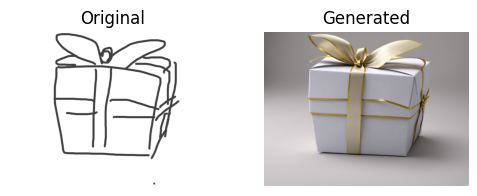

Best pair: 004.png | Score = 0.845139349466531
------------------------------------------------------------


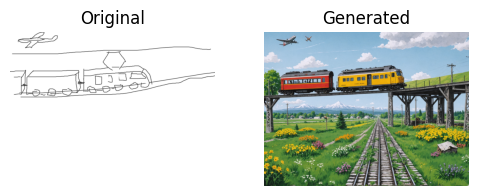

Worst pair: 005.png | Score = 0.11463610073376707
------------------------------------------------------------


In [73]:
best_idx = np.argmax(final_score)
worst_idx = np.argmin(final_score)

best_image = images[best_idx]
worst_image = images[worst_idx]

print_images(best_image)
print("Best pair:", best_image, "| Score =", final_score[best_idx])
print("-" * 60)

print_images(worst_image)
print("Worst pair:", worst_image, "| Score =", final_score[worst_idx])
print("-" * 60)

**4. Візуалізація**

  **4.1. Лінійні графіки нормалізованих значень**

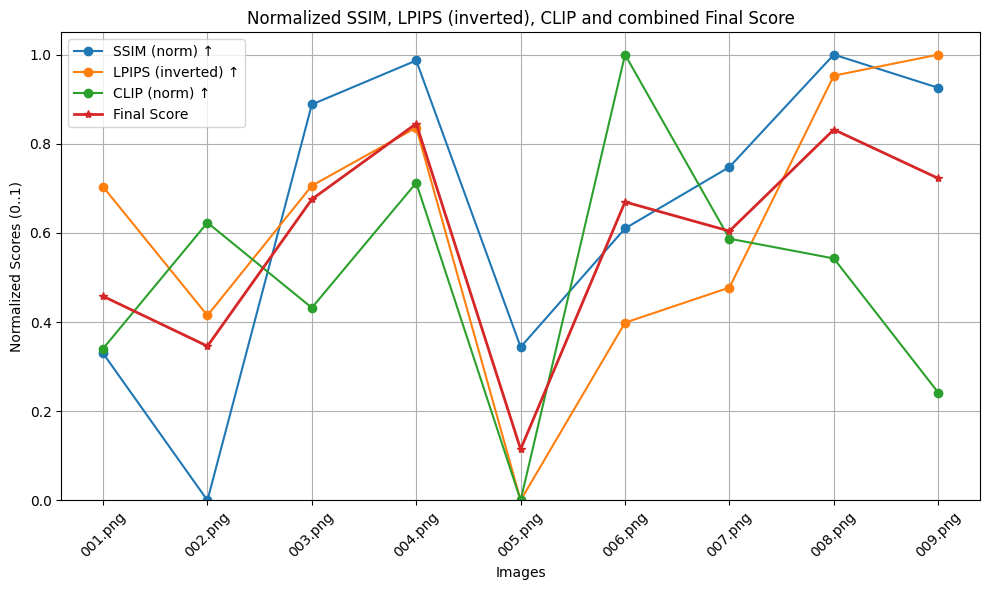

In [74]:
x = np.arange(len(images))  # 0..8
plt.figure(figsize=(10, 6))

plt.plot(x, ssim_norm, marker="o", label="SSIM (norm) ↑")
plt.plot(x, lpips_inverted, marker="o", label="LPIPS (inverted) ↑")
plt.plot(x, clip_norm, marker="o", label="CLIP (norm) ↑")
plt.plot(x, final_score, marker="*", linewidth=2, label="Final Score")

plt.xticks(x, images, rotation=45)
plt.ylim([0, 1.05])
plt.xlabel("Images")
plt.ylabel("Normalized Scores (0..1)")
plt.title("Normalized SSIM, LPIPS (inverted), CLIP and combined Final Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


- Тут ми порівнюємо **всі** нормалізовані метрики + фінальний `final_score`. 
- Можна відразу побачити, де найвища «комбінована оцінка».

  **4.2. Стовпчикові діаграми (Bar Chart) для фінального скору**

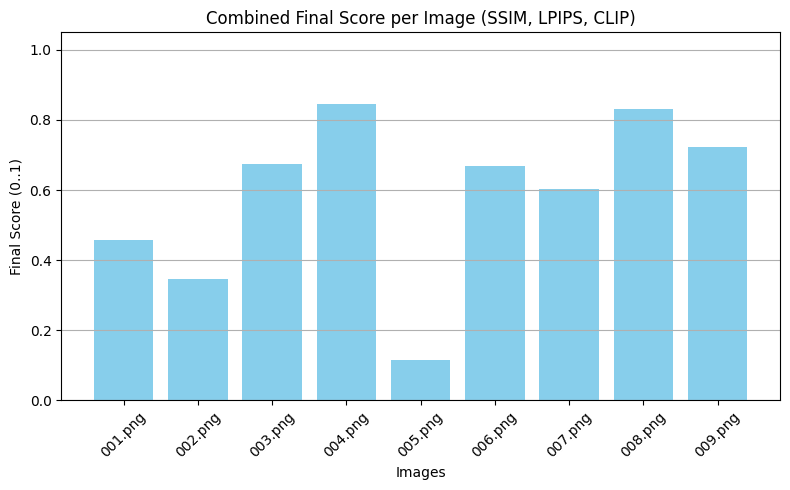

In [75]:
plt.figure(figsize=(8, 5))
plt.bar(x, final_score, color="skyblue")
plt.xticks(x, images, rotation=45)
plt.ylim([0, 1.05])
plt.xlabel("Images")
plt.ylabel("Final Score (0..1)")
plt.title("Combined Final Score per Image (SSIM, LPIPS, CLIP)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

**6. Приклад результатів і можливі висновки**

1. **Найкраща пара** (best pair) &mdash; та, у якої `final_score` найбільший. Це означає, що зображення має:  
   - Високий **SSIM** (добра структурна відповідність),  
   - Низький **LPIPS** (мала перцептивна різниця),  
   - Високу **CLIP**-подібність (семантично відповідає скетчу).  
2. **Найгірша пара** (worst pair) &mdash; протилежне (низький SSIM, високий LPIPS, низький CLIP тощо).  
3. За побудованим графіком можна швидко оцінити, як метрики корелюють. Можливо, якась пара має високий SSIM, але низький CLIP &mdash; тоді фінальний бал знизиться.  

Це лише *один зі способів* звести метрики в єдине число. Іноді дають різні ваги (наприклад, семантика важливіша за точне «піксельне» збереження), або ж додають інші метрики. У будь-якому разі, такий підхід допомагає **ранжувати** результати та знаходити найкращі/найгірші приклади для детального аналізу.

**Короткий Підсумок**
1. **Нормалізуємо** кожну метрику, пам’ятаючи, що SSIM/CLIP мають пряму корисність («більше = краще»), а LPIPS &mdash; зворотну.  
2. **Обчислюємо фінальний бал** шляхом простого усереднення (або з ваговими коефіцієнтами).  
3. **Визначаємо «best» і «worst»** зображення за цим інтегральним показником.  
4. **Візуалізуємо** результат у вигляді лінійних чи стовпчикових діаграм, аби наочно порівняти метрики й підсумковий score.


#### **Збір показників продуктивності**  
   - Усі обчислені значення (SSIM, LPIPS, CLIP Similarity) зберігаються в таблиці або у структурі даних (наприклад, `dict`), де для кожного зображення фіксуються чисельні результати.  
   - На основі цих даних можна будувати графіки (лінійні, стовпчикові) та робити порівняльний аналіз різних екземплярів чи різних гіперпараметрів моделі.


{'IMAGES': ['001.png', '002.png', '003.png', '004.png', '005.png', '006.png', '007.png', '008.png', '009.png'], 'SSIM': [0.4256296798226498, 0.2479114938641902, 0.7263351224273816, 0.7794633677082478, 0.4331593780830065, 0.5765090897529926, 0.6507597293726934, 0.7865663733872253, 0.746444452157249], 'LPIPS': [0.3872458040714264, 0.5153229236602783, 0.3862158954143524, 0.3283763527870178, 0.6993222236633301, 0.5225080847740173, 0.4875653386116028, 0.27667760848999023, 0.2557312846183777], 'CLIP': [0.7167180776596069, 0.7902816534042358, 0.7405835390090942, 0.8135316371917725, 0.6281437277793884, 0.8883845806121826, 0.7809145450592041, 0.7693694829940796, 0.6910591125488281]}


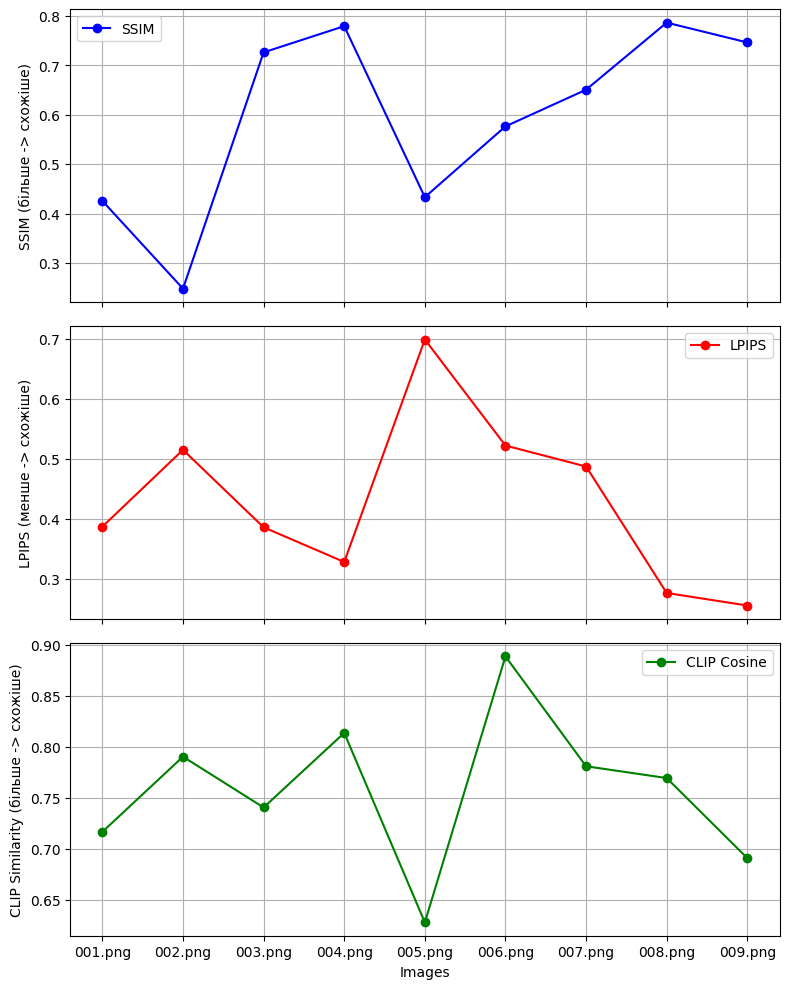

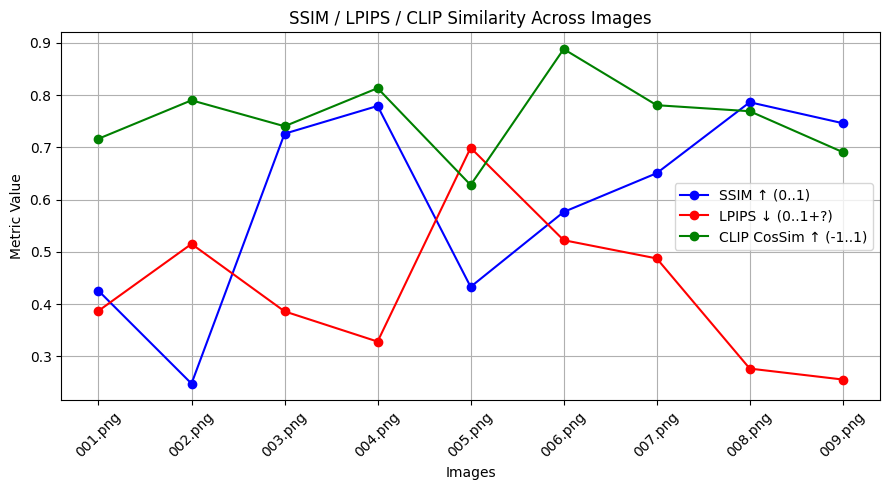

In [76]:
print(METRICS)

images = METRICS["IMAGES"]
ssim_values = METRICS["SSIM"]
lpips_values = METRICS["LPIPS"]
clip_values = METRICS["CLIP"]

# --------------------------------------------------------------------------
# Варіант A: Три окремі лінійні графіки (subplots)
# --------------------------------------------------------------------------
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 10), sharex=True)

axes[0].plot(images, ssim_values, marker="o", color="blue", label="SSIM")
axes[0].set_ylabel("SSIM (більше -> схожіше)")
axes[0].grid(True)
axes[0].legend()

axes[1].plot(images, lpips_values, marker="o", color="red", label="LPIPS")
axes[1].set_ylabel("LPIPS (менше -> схожіше)")
axes[1].grid(True)
axes[1].legend()

axes[2].plot(images, clip_values, marker="o", color="green", label="CLIP Cosine")
axes[2].set_ylabel("CLIP Similarity (більше -> схожіше)")
axes[2].set_xlabel("Images")
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()


# --------------------------------------------------------------------------
# Варіант B: Один графік із трьома лініями (за бажання)
# --------------------------------------------------------------------------
plt.figure(figsize=(9, 5))

plt.plot(images, ssim_values, marker="o", color="blue", label="SSIM ↑ (0..1)")
plt.plot(images, lpips_values, marker="o", color="red", label="LPIPS ↓ (0..1+?)")
plt.plot(images, clip_values, marker="o", color="green", label="CLIP CosSim ↑ (-1..1)")

plt.xlabel("Images")
plt.xticks(rotation=45)
plt.ylabel("Metric Value")
plt.title("SSIM / LPIPS / CLIP Similarity Across Images")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


##### 1. Короткий аналіз і висновки

###### 1.1. SSIM

1. Діапазон значень: від ~0.25 (мін.) до ~0.79 (макс.).  
2. **Чим вище SSIM**, тим більш *структурно подібні* пари (скетч vs згенероване).  
3. Найнижчі показники (напр. `0.2479` для 002.png) говорять про суттєві відмінності у локальних структурах/контурах, тоді як найвищі (\(\approx 0.78\)) для 008.png і 004.png означають, що згенеровані зображення краще зберігають **структуру** оригіналу.

###### 1.2. LPIPS

1. Діапазон: від ~0.25 (мін.) до ~0.70 (макс.).  
2. **Менше** &mdash; **більша** перцептивна схожість (тобто з точки зору deep-фільтрів, текстур, локальних патернів).  
3. Найменші значення (0.2557, 0.2767) спостерігаємо для 009.png і 008.png, що свідчить про *найближчу* відповідність.  
4. Найвищий LPIPS (0.6993) має 005.png, отже тут відмінності (з погляду “перцептивної” схожості) найпомітніші.

###### 1.3. CLIP Cosine Similarity

1. Діапазон: від ~0.63 до ~0.89.  
2. **Вище** &mdash; **краща** семантична відповідність (CLIP вважає, що зображення описують приблизно той самий вміст/об’єкт).  
3. Найвищий показник (0.8884) у 006.png вказує, що ця пара “скетч vs згенероване” найбільш “відповідають” одне одному за змістом.  
4. Найнижчі показники (близько 0.6281) у 005.png говорять, що CLIP бачить найбільшу різницю “сенсу” чи впізнаваних об’єктів між ескізом і підсумковим зображенням.


##### 2. Основні спостереження

1. **Часткові кореляції між метриками**:  
   - **SSIM** та **LPIPS** часто вказують на *подібність із точки зору структури та локальних патернів*. Якщо SSIM великий, LPIPS зазвичай менший.  
   - **CLIP**-подібність зосереджена на *семантичному* збігу. Тож 006.png, наприклад, має порівняно середній SSIM (0.5765) і LPIPS (0.5225), але дуже високий CLIP (0.8884). Це означає, що модель бачить схожий сюжет/об’єкт, хоч «текстури» чи «лінії» можуть відрізнятися.

2. **Найкращі пари з погляду «збереження структури»** (високий SSIM, низький LPIPS): 008.png, 009.png, 004.png, 003.png.  
3. **Найкращі пари з погляду «семантики»** (високий CLIP): 006.png (0.8884), 004.png (0.8135), 002.png (0.7903).  
   - Цікаво, що 002.png має низький SSIM (~0.25), але високий CLIP (~0.79). Тобто структурно вони дуже різні, але CLIP бачить “один і той самий” об’єкт/категорію.  
4. **Найбільш «відхилений» результат** з усіх боків &mdash; 005.png, де LPIPS = 0.6993 (найвищий), CLIP = 0.6281 (найнижчий), а SSIM = 0.4332 (посередній).

###### Підсумок
- Високий **SSIM** = *близька структура*.  
- Низький **LPIPS** = *ближчі локальні текстури/патерни*.  
- Високий **CLIP** = *більш подібний зміст/сюжет/об’єкт*.  

Залежно від **вашої цілі** (наприклад, зберегти контур ескізу чи відтворити «семантичну» сцену), показники можуть вказувати, яке зображення (або який метод генерації) вам підходить найкраще. Для повноти аналізу варто також **переглянути зображення вручну**, оскільки автоматичні метрики дають корисні, але не завжди вичерпні оцінки «якості».


#### **Суб’єктивна (людська) оцінка**  
   - Оскільки модель часто генерує *креативні* зображення, варто додатково **залучити рецензентів** чи команду дизайнерів, щоби перевірити, наскільки результат відповідає естетичним або художнім критеріям.  
   - Їм можна показати ескізи та згенеровані картинки та попросити оцінити «загальну якість», «правдоподібність» або «відповідність» задуму за певною шкалою.

У результаті проведеної оцінки ми отримаємо *кількісні показники* (SSIM, LPIPS, CLIP) і *якісні зауваження* від реальних користувачів. Це дозволяє об’єктивно порівняти різні варіанти моделі, знайти найсильніші та найслабші сторони системи та визначити напрямки подальшого покращення.